In [1]:
%matplotlib inline
%load_ext line_profiler

from tiptop import *

In [2]:
fullInputPath = "perfTest"
parametersFile = "HarmoniLTAO_1"
#parametersFileGPU = 'params1GPU'
#parametersFileCPU = 'params1CPU'
windPsdFile = 'MASTSEL/data/windpsd_mavis.fits'
baseOutpuPath = 'perfTest'
outputFile = "test"


Vectorize the wavelength value to cope with the number of LGS sources
Vectorize the wavelength value to cope with the number of NGS sources
Vectorize the wavelength value to cope with the number of SCIENCE sources
fao.samp: [2.90886265]
SR at the sensing wavelength: 0.6574485151807048
FWHM at the sensing wavelength: 12.840753649893347
SR at the sensing wavelength: 0.6543749279802946
FWHM at the sensing wavelength: 12.838271679929347
SR at the sensing wavelength: 0.650222384068446
FWHM at the sensing wavelength: 12.839018572899553
SR at the sensing wavelength: 0.4447086627963867
FWHM at the sensing wavelength: 12.873899078283259
SR at the sensing wavelength: 0.4409772957330858
FWHM at the sensing wavelength: 12.863368155485176
SR at the sensing wavelength: 0.43640672808791536
FWHM at the sensing wavelength: 12.867049847508829
SR at the sensing wavelength: 0.26611836827870927
FWHM at the sensing wavelength: 12.942318562899409
SR at the sensing wavelength: 0.2620540154512288
FWHM at the 

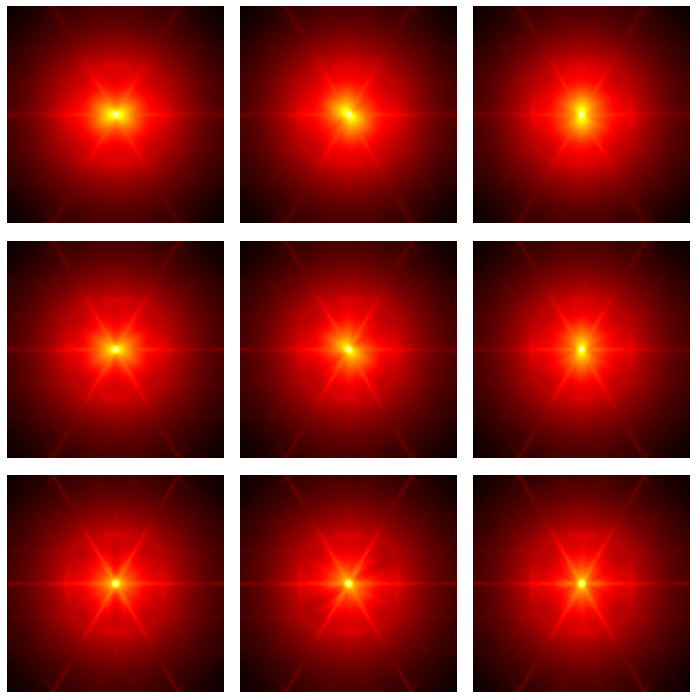

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


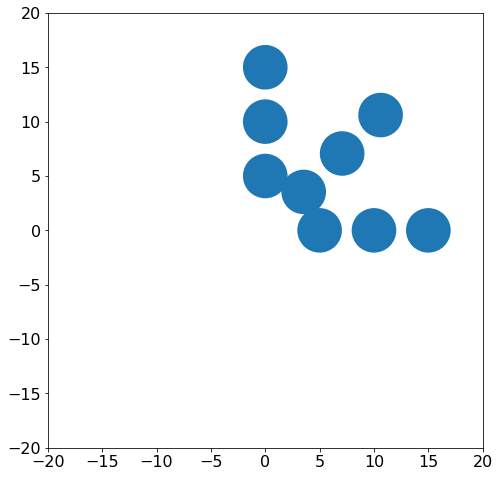

Output cube shape: (9, 640, 640)


In [3]:
# %lprun -f MavisLO.computeTotalResidualMatrix 
overallSimulation(fullInputPath, parametersFile, windPsdFile, baseOutpuPath, outputFile, doPlot=True, doConvolve=True, pitchScaling = 0.9)

In [4]:
%%time
overallSimulation(fullInputPath, parametersFileGPU, windPsdFile, baseOutpuPath, outputFile, doConvolve=True, pitchScaling = 0.9)

NameError: name 'parametersFileGPU' is not defined

In [5]:
%%time
overallSimulation(fullInputPath, parametersFileCPU, windPsdFile, baseOutpuPath, outputFile, doConvolve=True, pitchScaling = 0.9)

NameError: name 'parametersFileCPU' is not defined

In [6]:
%lprun -f MavisLO.computeTotalResidualMatrix overallSimulation(fullInputPath, parametersFileCPU, windPsdFile, baseOutpuPath, outputFile, doConvolve=True, pitchScaling = 0.9)

NameError: name 'parametersFileCPU' is not defined

In [ ]:
# MAVIS SIMULATIONS
baseInputPath = '/data7/guido/results/MAVIS/res4psf/20201116_111006.0_oaPSFs_w'
baseOutpuPath = '/data4/frossi/'
windPsdFile = 'MASTSEL/data/windpsd_mavis.fits'

wvlPaths = ['450','550','640','890']
k=-1
for wvlPath in wvlPaths:
    k+=1
    fullInputPath = baseInputPath + wvlPath + 'nm/'
    parametersFile = 'params'
    outputFile = 'simulation' + wvlPath + 'nm'
    overallSimulation(fullInputPath, parametersFile, windPsdFile, baseOutpuPath, outputFile,doConvolve=True,pitchScaling = 0.9)
print('Done')